In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv
import torch
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
import ot
from tqdm import tqdm
import sys
sys.path.append("../")
from lib.linear_gromov import *
from lib.gromov_barycenter import *
from lib.opt import opt_lp,emd_lp
from lib.gromov import *
from sklearn import manifold
from sklearn.decomposition import PCA

from sklearn.datasets import load_digits
from sklearn.manifold import MDS
import ot

from sklearn import manifold

import numpy as np
import matplotlib.pyplot as plt
import h5py
import seaborn as sns
import plotly
import plotly.express as px
import sklearn
import pandas as pd
import random

from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import dijkstra

from utils import *


In [40]:
def GW_interporlation(X1,X2,t_list=[0,0.5,1],p1=None,p2=None,loss='sqrt',method='GW',M_ref=None,pmf_ref=None,Lambda=None,loss_param=None):
    assert method in ['GW','LGW','PGW','LPGW']
    assert loss in ['sqrt','graph']
    
    M1=X_to_C(X1,loss=loss,loss_param=loss_param)
    M2=X_to_C(X2,loss=loss,loss_param=loss_param)
    n1,n2,d=M1.shape[0],M2.shape[0],X1.shape[1]
    Ms=[M1,M2]
    ps=[p1,p2]

    clf=PCA(n_components=2)
    
    Mt_list,Xt_list,pmf_list=[],[],[]
    if M_ref is not None:
        N=M_ref.shape[0]
    else:
        N=int(np.mean([n1,n2]))+1
    if method in ['GW','LGW']:
        ps=[p/p.sum() for p in ps]
    if method =='LGW':
        if M_ref is None:
            N=int(np.mean([n1,n2]))+1
            pmf_ref=np.ones(N)/N
            M_ref=ot.gromov.gromov_barycenters(N, Cs = Ms,
                                            ps = ps, p = pmf_ref, lambdas = ot.unif(2), 
                                            max_iter=100, tol=1e-5,random_state=0,log=False)
        embedding_list=[]
        for (X,pmf,M) in zip([X1,X2],ps,Ms):
            gamma=gromov_wasserstein(M_ref, M, pmf_ref, pmf, G0=None, thres=1, numItermax=500*N, tol=1e-5,log=False, verbose=False,line_search=True)
            embedding,_=LGW_embedding(M_ref,X,pmf_ref,pmf,gamma,loss=loss,loss_param=loss_param)
            embedding_list.append(embedding)

    elif method =='LPGW':
        if Lambda is None:
            Lambda=max(M1.max(),M1.max())/2
        
        if M_ref is None:
            
            pmf_ref=np.ones(N)/N
            M_ref=pgw_barycenters(N, Cs = [M1,M2],
                                            ps = [p1,p2], p = pmf_ref, lambdas = ot.unif(2), Lambda_list=[Lambda,Lambda],
                                            max_iter=100, tol=1e-5,log=False)
        embedding_list=[]
        for (X,pmf,M) in zip([X1,X2],ps,Ms):
            gamma=partial_gromov_ver1(M_ref, M, pmf_ref, pmf, G0=None,Lambda=Lambda, thres=1, numItermax=500*N, tol=1e-5,log=False, verbose=False,line_search=True)
            embedding,_=LPGW_embedding(M_ref,X, pmf_ref, pmf, gamma,Lambda,loss=loss,loss_param=loss_param) 
            embedding_list.append(embedding[0])
            pmf_list.append(embedding[0])
        

    elif method=='GW':
        for t in t_list:
            lambdas=[1-t,t]
            #normalize qs
            C=ot.gromov.gromov_barycenters(
                N=N, Cs=Ms, ps=ps, p=pmf_ref, lambdas=lambdas,init_C=M_ref, 
                symmetric=True, armijo=False, max_iter=1000, tol=1e-5)
            Mt_list.append(C)
    elif method =='PGW':
        for t in t_list:
            lambdas=[1-t,t]
            C=pgw_barycenters(
                N=N, Cs=Ms, ps=ps, p=pmf_ref, lambdas=lambdas,Lambda_list=[Lambda,Lambda],loss_fun='square_loss',
                init_C=M_ref, max_iter=1000, tol=1e-5)
            
            Mt_list.append(C)
        #return Mt_list,
        
        
        
        
    if method in ['LGW','LPGW']:
        E1,E2=embedding_list[0],embedding_list[1]
        for t in t_list:
            Mt=M_ref+(1-t)*E1+t*E2
            Mt_list.append(Mt)
    
    if method =='LPGW':
        pmf=np.minimum(pmf_list[0],pmf_list[1])
    else:
        pmf=pmf_ref
    # convert Mt to Xt
    mds = MDS(n_components=2, metric=True,dissimilarity='precomputed',random_state=0,normalized_stress='auto')

    
    for Mt in Mt_list:
        Xt=mds.fit_transform(Mt)
        #Xt=clf.fit_transform(Xt.copy())
        Xt_list.append(Xt)
    return Xt_list,Mt_list,pmf

In [92]:
# load reference 
ref=torch.load('data/ref.pt')
pos_ref=ref['pos_ref']
M_ref=ref['M_ref']
pmf_ref=ref['pmf_ref']
print(pmf_ref.shape)
eta_list=[0,0.05,0.10,0.3,0.5]

loss='sqrt'
idx1=2
idx2=4

# load data 
labels=[0,1,2,3,4,6,7,8]
df = pd.read_csv("data/train.csv")
train_X = df[df.columns[1:]].to_numpy()
train_y = df[df.columns[0]].to_numpy()
train_X = train_X.reshape(train_X.shape[0], -1, 3)

    
size1=10
train_X_sample_pos,train_X_sample_pmf,train_Y_sample=sample_dataset(train_X,train_y,labels=labels,sample_size=size1)
train_X_sample_pos1,train_X_sample_pmf1=process_dataset(train_X_sample_pos,train_X_sample_pmf,eta=0,seed=2)

X1=train_X_sample_pos[size1*idx1]
p1=train_X_sample_pmf[size1*idx1]

X2=train_X_sample_pos[size1*idx2]
p2=train_X_sample_pmf[size1*idx2]

X3,p3=add_noise(X2,p2,eta=0.3,mass=1,seed=1,low_bound=-20,upper_bound=20)





        





(201,)


80it [00:00, 19646.60it/s]
80it [00:00, 7148.52it/s]


In [93]:
print(p3.sum())

1.3


In [85]:
t_list=np.linspace(0,1,7)
method_list=['GW','PGW','LGW','LPGW']
for method in method_list:
    print('method is',method)
    st=time.time()
    Lambda=50
    Xt_list,_,pmf=GW_interporlation(X1,X3,t_list=t_list,p1=p1,p2=p3,loss='sqrt',method=method,M_ref=M_ref,pmf_ref=pmf_ref,Lambda=Lambda,loss_param=None)
    et=time.time()
    print('wall_time is',et-st)
    torch.save([Xt_list,pmf],'results_interpolation/%s_1.pt'%(method))

1.0

method is GW
method is PGW
method is LGW
method is LPGW


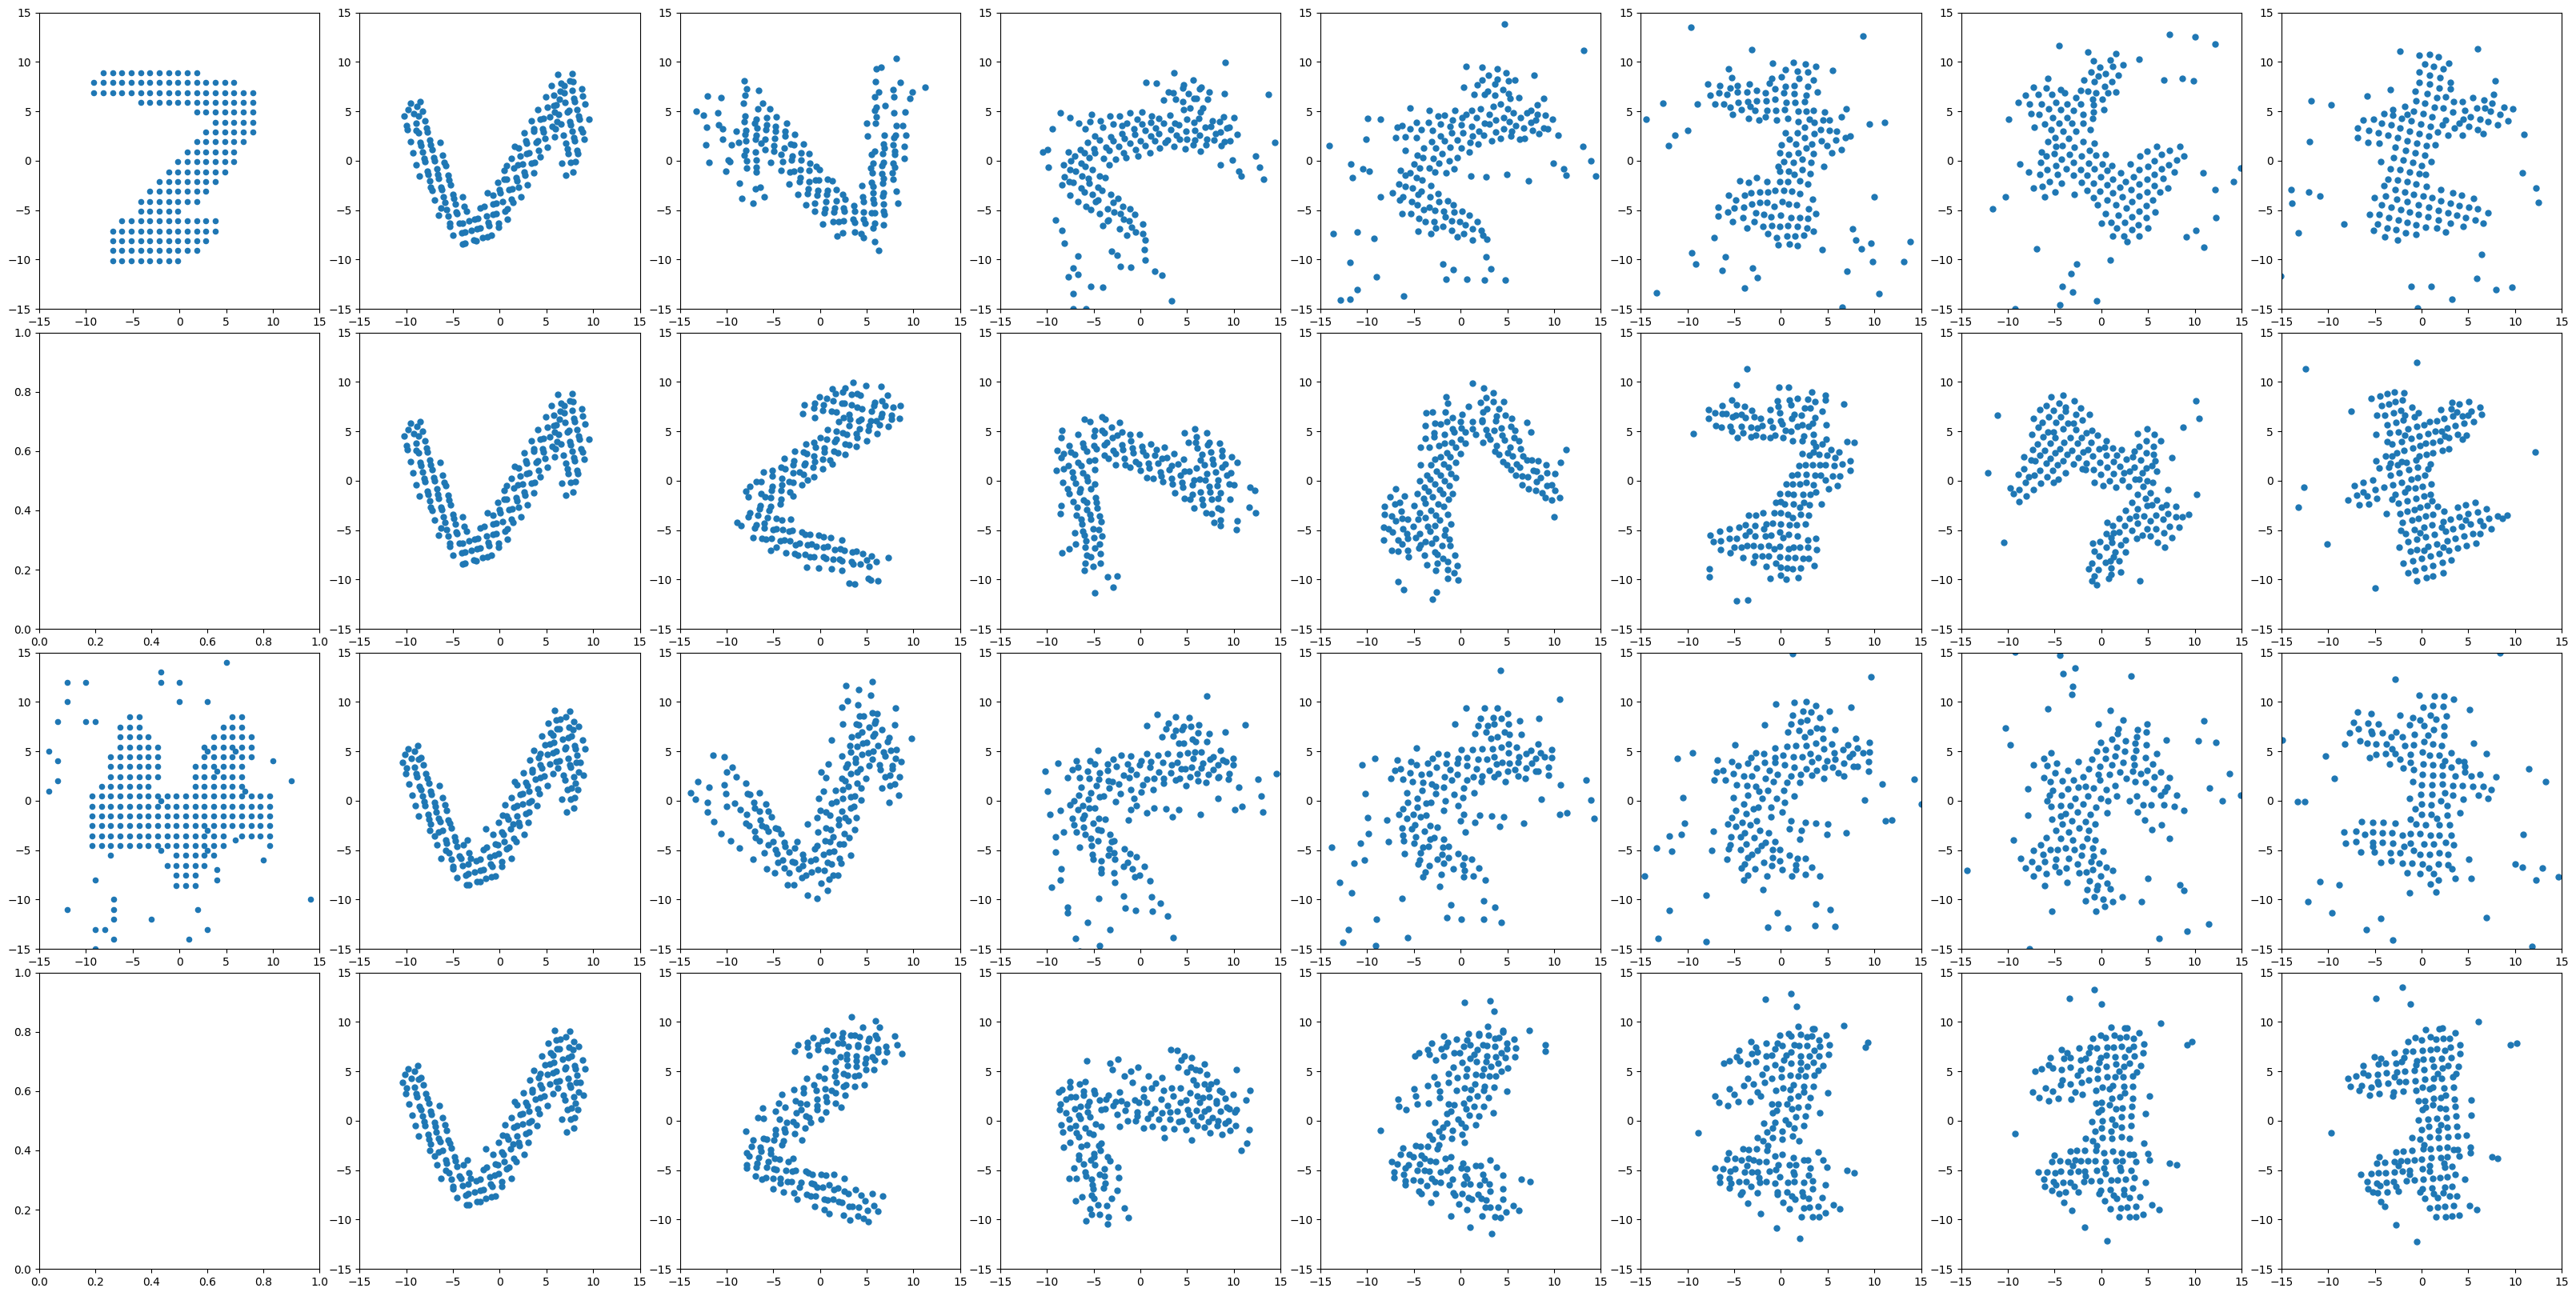

In [55]:
method_list=['GW','PGW','LGW','LPGW']
fig, axs = plt.subplots(4, 8, figsize=(4*8, 4*4))

# R_gw_p=np.array([-0.45*np.pi, -0.6*np.pi, 1/2*np.pi, np.pi, np.pi, np.pi, np.pi, np.pi])
# R_pgw_p=np.array([0.3*np.pi, 3/4*np.pi, 1/2*np.pi, np.pi, np.pi, np.pi, np.pi, np.pi])

# flip_M=np.array([[0,1],[1,0]])

# F_gw=np.array ([[        0,         0,           1,          1,         1,          1,          1,       1],
#                 [        0,         0,           0,          0,         0,          0,          0,       0],
#                 [        0,         1,           1,          0,         0,          0,          0,       0],
#                 [        0,         1,           1,          1,         1,          0,          0,       0],
#                 [        0,         1,           1,          1,         1,          1,          1,       0],
#                 [        0,         1,           1,          1,         0,          0,          1,       0]])

# F_pgw=np.array([[        0,         0,           0,          0,         0,          0,          0,       0],
#                 [        0,         0,           0,          0,         0,          0,          0,       0],
#                 [        0,         0,           0,          0,         0,          0,          0,       1],
#                 [        0,         0,           0,          0,         0,          1,          1,       1],
#                 [        0,         0,           0,          0,         0,          1,          1,       0],
#                 [        0,         0,           0,          1,         0,          1,          1,       1]])

# R_gw= np.array([[0.85*np.pi,  0.8 *np.pi, 1.4*np.pi, 1.4*np.pi, 1.4*np.pi, 1.35*np.pi, 1.35*np.pi, 1.15*np.pi],
#                 [0.85*np.pi,  0.85*np.pi, 1.0*np.pi, 1.4*np.pi, 1.4*np.pi, 1.35*np.pi, 1.25*np.pi, 1.25*np.pi],
#                 [0.85*np.pi,  1.35*np.pi, 1.3*np.pi, 1.7*np.pi, 1.7*np.pi, 1.75*np.pi, 1.75*np.pi, 1.75*np.pi],
#                 [0.85*np.pi,  1.35*np.pi, 1.3*np.pi, 1.3*np.pi, 1.3*np.pi, 1.65*np.pi, 1.75*np.pi, 1.75*np.pi],
#                 [0.85*np.pi,  1.25*np.pi, 1.3*np.pi, 1.3*np.pi, 1.35*np.pi,1.25*np.pi, 1.25*np.pi, 0.75*np.pi],
#                 [0.85*np.pi,  1.25*np.pi, 1.3*np.pi, 1.3*np.pi, 0.8*np.pi, 0.85*np.pi, 1.25*np.pi, 0.75*np.pi]
#               ])
# R_pgw=np.array([[0.85*np.pi, 0.85*np.pi, 0.85*np.pi, 0.8*np.pi, 0.8*np.pi, 0.75*np.pi, 0.75*np.pi, 0.75*np.pi],
#                 [0.85*np.pi, 0.85*np.pi, 0.85*np.pi, 0.8*np.pi, 0.8*np.pi, 0.75*np.pi, 0.75*np.pi, 0.75*np.pi],
#                 [0.85*np.pi, 0.85*np.pi, 0.85*np.pi, 0.8*np.pi, 0.8*np.pi, 0.85*np.pi, 0.75*np.pi, 0.25*np.pi],
#                 [0.85*np.pi, 0.85*np.pi, 0.85*np.pi, 0.8*np.pi, 0.8*np.pi, 1.25*np.pi, 0.25*np.pi, 1.25*np.pi],
#                 [0.85*np.pi, 0.85*np.pi, 0.85*np.pi, 0.8*np.pi, 0.8*np.pi, 0.35*np.pi, 1.25*np.pi, 0.75*np.pi],
#                 [0.85*np.pi, 0.85*np.pi, 0.85*np.pi, 1.3*np.pi, 0.8*np.pi, 1.25*np.pi, 1.25*np.pi, 0.25*np.pi]
#               ])


# visulize original data: 
# for i in range(2*2*3):
#     for j in range(9):
#         ax[i,j].set_xticks([])
#         ax[i,j].set_yticks([])
#         if j>=1:
#             ax[i,j].set_xlim([-0.6, 0.5])
#             ax[i,j].set_ylim([-0.5, 0.5]) 

i_row=0
for i,dtype in enumerate(['1']):
    
    for i1,method in enumerate(method_list):
        print('method is',method)

        
        result=torch.load('results_interpolation/%s_%s.pt'%(method,dtype))[0]
        for j,t in enumerate(t_list):
            ax=axs[i_row,j+1]
            X=result[j]
            
            
            ax.scatter(X[:,0], X[:,1],s=25.0)
            ax.set_xlim([-15,15])
            ax.set_ylim([-15,15])
        
        i_row+=1
for i,X in enumerate([X1,X3]):
    ax=axs[i*2,0]
    ax.scatter(X[:,0],X[:,1],s=20.0)
    ax.set_xlim([-15, 15])
    ax.set_ylim([-15, 15]) 
        
        
    
        

        

plt.tight_layout(pad=0.0)

    
plt.show()

In [110]:
size1=10
train_X_sample_pos,train_X_sample_pmf,train_Y_sample=sample_dataset(train_X,train_y,labels=labels,sample_size=size1)
train_X_sample_pos1,train_X_sample_pmf1=process_dataset(train_X_sample_pos,train_X_sample_pmf,eta=0,seed=2)

idx1=2
idx2=2

X1=train_X_sample_pos[size1*idx1]
p1=train_X_sample_pmf[size1*idx1]

X2=train_X_sample_pos[size1*idx2]
p2=train_X_sample_pmf[size1*idx2]

X3,p3=add_noise(X2,p2,eta=0.3,mass=1,seed=1,low_bound=-20,upper_bound=20)


p3=p3/p3.sum()*(1+0.3)
def LOT_recontruct(X,pmf,pos_ref,pmf_ref):
    embedding=lot_embedding(pos_ref,X,pmf_ref/pmf_ref.sum(),pmf/pmf.sum())
    X_hat=pos_ref+embedding
    return X_hat
    
label_list=['data','LOT','LGW','LPGW']

j=0
for X,pmf in [(X2,p2),(X3,p3)]:
    result_list=[]
    result_list.append(X)
    X_hat= LOT_recontruct(X,pmf,pos_ref,pmf_ref)
    result_list.append(X_hat)
    
    for method in ['LGW','LPGW']:
        print('method',method)
        X_hat_list,_,_=GW_interporlation(X,X,[0],p1=pmf,p2=pmf,loss='sqrt',method=method,M_ref=M_ref,pmf_ref=pmf_ref,Lambda=50,loss_param=None)
        result_list.append(X_hat_list[0])
    torch.save(result_list,'results_visual/X_%i.pt'%j)
    j+=1
    
    


80it [00:00, 21132.66it/s]
80it [00:00, 7032.41it/s]


method LGW
method LPGW
method LGW
method LPGW


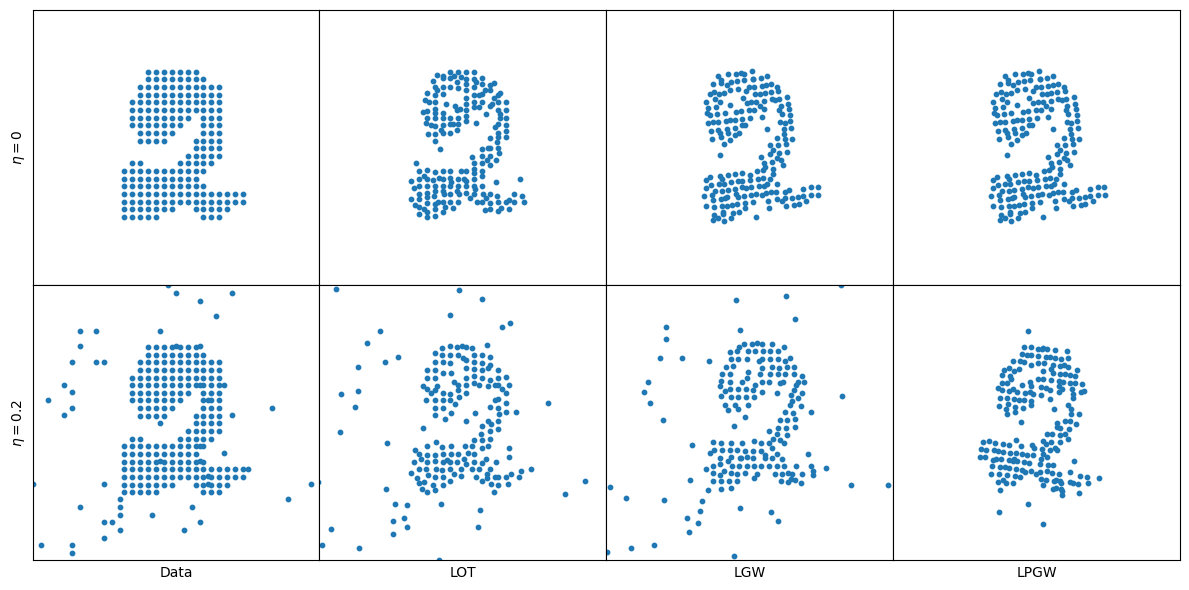

In [122]:
import torch
import matplotlib.pyplot as plt
def rotation_2d(angle):
    """
    Computes a 2D rotation matrix.

    Parameters:
    angle (float): The rotation angle in radians.

    Returns:
    numpy.ndarray: A 2x2 rotation matrix.
    """
    return np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle),  np.cos(angle)]
    ])

def flipping(x=True):
    if x:
        return np.array([[0,1],[1,0]])
    else:
        return np.array([[1,0],[0,1]])
# Create figure and subplots
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
theta_list=np.array([-1,-1,1.5,0.35])*np.pi
F_list=[0,0,1,0]
# Remove all x, y ticks and labels
for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
idx=0
for i,result in enumerate(['X_0','X_1']):
    X_list=torch.load('results_visual/%s.pt'%result)
    for j in range(4):
        X=X_list[j]
        if j>=2:
            R=rotation_2d(theta_list[idx])
            F=flipping(F_list[idx])
            idx+=1
            X=X.dot(R).dot(F)
        axes[i, j].scatter(X[:, 0], X[:, 1], s=10)
        axes[i,j].set_xlim([-18, 18])
        axes[i,j].set_ylim([-18, 18])
        



# Add x-labels to the last row
x_labels = ['Data', 'LOT', 'LGW', 'LPGW']
for i, xlabel in enumerate(x_labels):
    axes[1, i].set_xlabel(xlabel,fontsize=30)

# Add y-labels to the first column
y_labels = [r'$\eta=0$', r'$\eta=0.2$']
for i, ylabel in enumerate(y_labels):
    axes[i, 0].set_ylabel(ylabel,fontsize=30)

# Adjust layout and show plot
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('results_visual/embedding.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
pos_ref

In [7]:
pos_ref.shape

(201, 2)

In [8]:
X.shape

(134, 2)

In [11]:
pmf.shape

(134,)